In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from preprocessing.house_zero_preprocessing import serve_data_hz

from models.context_unet import ContextUnet

import ddpm.cu_ddpm as ddpm

from evaluation.pca_tsne import visualize_pca_tsne
from evaluation.jsd import compute_jsd

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

0

In [3]:
config_path = "./config.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
subset_len = config["subset_len"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])
dataset_name = config["dataset"]
house_zero_feature_subset = config["house_zero_feature_subset"]
img_rows = int(config["img_rows"])
img_cols = int(config["img_cols"])
channels = int(config["channels"])
n_feat = int(config["n_feat"])

assert model_name in ["ContextUnet"], "Chosen  model was not valid, the option is ContextUnet"
assert cond_model in {"mlp", "te", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te and stft"
if (model_name, dataset_name) == ("ContextUnet", "LondonDataStore"):
    raise AssertionError("Chosen model is not compatible with chosen dataset")

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
train_loader, test_loader, n_cfeat = serve_data_hz(batch_size=batch_size_config, channels=channels, feature_subset=house_zero_feature_subset)

torch.Size([14035, 1, 8, 8]) torch.Size([14035, 8])


# Model

In [5]:
model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=img_cols, cond_model=cond_model).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

## DDPM

# Train

In [6]:
model.train()
for ep in range(epochs):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lr*(1-ep/epochs)

    pbar = tqdm(train_loader, mininterval=2 )
    epoch_loss = 0.0   # initialize epoch loss
    n_batches = 0      # count number of batches
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        noise = noise.type(torch.float32)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = ddpm.perturb_input(x, t, noise, beta1=betas[0], beta2=betas[1], timesteps=timesteps, device=device)

        # use network to recover noise
        time = t / timesteps
        time = time.type(torch.float32)
        x_pert = x_pert.type(torch.float32)
        c = c.type(torch.float32)
        
        pred_noise = model(x_pert, time, c=c)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        epoch_loss += loss.item()
        n_batches += 1
        loss.backward()

        optim.step()

epoch 0


100%|██████████| 220/220 [00:05<00:00, 43.07it/s]


epoch 1


100%|██████████| 220/220 [00:04<00:00, 44.76it/s]


epoch 2


100%|██████████| 220/220 [00:04<00:00, 45.98it/s]


epoch 3


100%|██████████| 220/220 [00:04<00:00, 45.96it/s]


# Sampling

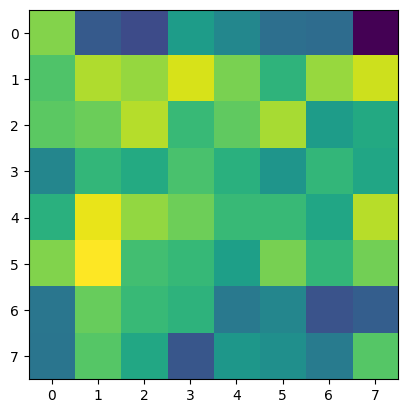

In [7]:
sample, _ = ddpm.sample_ddpm_context(n_sample=1, context=None, channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
sample = sample.cpu().numpy()
sample = np.transpose(sample, (0, 2, 3, 1))
sample = sample.squeeze(-1)
plt.imshow(sample.squeeze())

# Evaluation
## Without Conditioning
### Train

In [8]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([64, 8]), torch.Size([64, 1, 8, 8]))

### Test

## With Conditioning